In [2]:
import sys
import os

import random
import math

import torch 
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

sys.path.append('../..')
from lib.schedulers import DelayedScheduler
from lib.datasets import (max_lbl_nums, actual_lbl_nums, 
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          get_train_test_img_ids_split)
from lib.dataloaders import PatchesDataset, WSIPatchesDatasetRaw
from lib.augmentations import augment_v1_clr_only, augment_empty_clr_only
from lib.losses import SmoothLoss

from lib.models.unetv1 import get_model

from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# import cv2
import numpy as np
# import pandas as pd
# from lib.datasets import patches_csv_path, patches_path
from lib.datasets import patches_clean90_csv_path as patches_csv_path, patches_path
# from lib.dataloaders import imread, get_g_score_num, get_provider_num

In [3]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

In [4]:
len(train_img_ids)

8420

In [5]:
test_img_ids[:4]

['e8baa3bb9dcfb9cef5ca599d62bb8046',
 '9b2948ff81b64677a1a152a1532c1a50',
 '5b003d43ec0ce5979062442486f84cf7',
 '375b2c9501320b35ceb638a3274812aa']

In [6]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

In [7]:
max_len = 300

In [8]:
main_device = torch.device('cuda:1')

In [9]:
from tqdm.auto import tqdm

In [10]:
train_batch_path = '/mnt/SSDData/pdata/processed/tmp/tmp{}/'
test_batch_path = '/mnt/SSDData/pdata/processed/tmp/val_tmp/'

In [11]:
class WSIPatchesDummyDataset(torch.utils.data.Dataset):
    def __init__(self, batch_path):
        self.batch_path = batch_path
        self.idxs = list(range(len(os.listdir(batch_path)) // 2))

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        features = torch.load(os.path.join(self.batch_path, f"features_{idx}.pth"), map_location='cpu')
        target = torch.load(os.path.join(self.batch_path, f"target_{idx}.pth"), map_location='cpu')

        return features, target

In [12]:
#empty_mask = (main_features.view(b, max_len, -1) == 0).all(dim=-1)[..., None, None, None]
#dummy_feature = nn.Parameter(torch.ones((1, 1, 512, 8, 8), dtype=torch.float32, device=main_device))
#main_features = main_features + empty_mask * dummy_feature.expand(b, 1, 512, 8, 8)

In [17]:
f_d_rate = 0.5
d_rate = 0.4

class MainModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # self.dummy_feature = nn.Parameter(torch.randn((1, 512, 1), dtype=torch.float32))
        
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(512),
            #nn.Dropout(f_d_rate),

            nn.Conv1d(512, 64, 1),
            #nn.Conv1d(512*8*8, 64, 1),
            nn.ReLU(inplace=True),
            #nn.Dropout(d_rate),
            nn.BatchNorm1d(64),

            nn.Conv1d(64, 64, 1),
            nn.ReLU(inplace=True),
            #nn.Dropout(d_rate),
            nn.BatchNorm1d(64),

            nn.AdaptiveMaxPool1d(1),
            LambdaLayer(lambda x: x.view(-1, 64)),

            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            #nn.Dropout(d_rate),
            nn.BatchNorm1d(64),
            # nn.LayerNorm(64),
        )
        
        self.reg_linear = nn.Linear(64, 1)
        self.class_linear = nn.Linear(64, max_lbl_nums)

    def forward(self, x):
        # b, 300, 512
        b = x.shape[0]
        
        # empty_mask = (x == 0).all(dim=1)[:, None, :]
        # x = x + empty_mask * self.dummy_feature.expand(b, 512, max_len)
        
        x = self.backbone(x)
        return self.reg_linear(x), self.class_linear(x)

main_model = MainModel().to(main_device)

In [18]:
sum([p.data.numel() for p in main_model.parameters()])

43015

In [19]:
optimizer = optim.Adam(main_model.parameters(), lr=0.0004, weight_decay=2e-3)
# optimizer = optim.SGD(main_model.parameters(), lr=0.01, weight_decay=2e-3)
# optimizer = optim.SGD(main_model.parameters(), lr=0.01, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94, last_epoch=-1)

criterion_reg = nn.MSELoss()
criterion_class = SmoothLoss(lambda o, t: F.kl_div(o, t), smoothing=0.1, one_hot_target=True)
# criterion = lambda output, target: ((output-target)**3).abs().mean() / 2.0
# w_reg, w_class = 1, 0
w_reg, w_class = 1 / 2, 9 / 2
# w_reg, w_class = 0.2, 8 

In [20]:
val_loader = torch.utils.data.DataLoader(WSIPatchesDummyDataset(test_batch_path),
                                         batch_size=1, shuffle=False, num_workers=4,
                                         pin_memory=True)

n = 0
for epoch in tqdm(range(50)):
    train_loader = torch.utils.data.DataLoader(WSIPatchesDummyDataset(train_batch_path.format(epoch % 10)),
                                               batch_size=1, shuffle=True, num_workers=4,
                                               pin_memory=True)
    
    main_model.train()
    
    mean_train_loss = 0
    mean_train_acc_reg = 0
    mean_train_acc_class = 0    
    mean_train_qwk_reg = 0
    mean_train_qwk_class = 0    
    
    train_cnt = len(train_loader)
    for features, target in train_loader:
        b = features.shape[0]

        features, target = features[0].to(main_device), target[0].to(main_device)
        target_reg = target[:, None].float()
        target_class = target
        del target

        optimizer.zero_grad()

        output_reg, output_class = main_model(features)
        output_reg = torch.sigmoid(output_reg) * max_lbl_nums
        output_class = F.log_softmax(output_class, dim=-1)
        
        loss = (w_reg * criterion_reg(output_reg, target_reg) +
                w_class * criterion_class(output_class, target_class))
            

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(main_model.parameters(), 0.01)
        optimizer.step()
        # lr_scheduler.step()

        o_output_reg = output_reg.round().long().clamp(0, 5)
        o_output_class = output_class.argmax(dim=-1)
        
        acc_reg = o_output_reg.eq(target_reg).float().mean()
        acc_class = o_output_class.eq(target_class).float().mean()        
        
        qwk_reg = cohen_kappa_score(o_output_reg.cpu().numpy(), target_reg.cpu().numpy(), weights="quadratic")
        qwk_class = cohen_kappa_score(o_output_class.cpu().numpy(), target_class.cpu().numpy(), weights="quadratic")        
        
        mean_train_loss += loss.item() / train_cnt
        mean_train_acc_reg += acc_reg.item() / train_cnt
        mean_train_acc_class += acc_class.item() / train_cnt        
        mean_train_qwk_reg += qwk_reg / train_cnt
        mean_train_qwk_class += qwk_class / train_cnt
    
    lr_scheduler.step()

    main_model.eval()
    with torch.no_grad():
        mean_val_loss = 0
        mean_val_acc_reg = 0
        mean_val_acc_class = 0    
        mean_val_qwk_reg = 0
        mean_val_qwk_class = 0  

        val_cnt = len(val_loader)
          
        for features, target in val_loader:
            b = features.shape[0]

            features, target = features[0].to(main_device), target[0].to(main_device)
            target_reg = target[:, None].float()
            target_class = target
            del target

            output_reg, output_class = main_model(features)
            output_reg = torch.sigmoid(output_reg) * max_lbl_nums
            output_class = F.log_softmax(output_class, dim=-1)

            loss = (w_reg * criterion_reg(output_reg, target_reg) +
                    w_class * criterion_class(output_class, target_class))

            o_output_reg = output_reg.round().long().clamp(0, 5)
            o_output_class = output_class.argmax(dim=-1)

            acc_reg = o_output_reg.eq(target_reg).float().mean()
            acc_class = o_output_class.eq(target_class).float().mean()        

            qwk_reg = cohen_kappa_score(o_output_reg.cpu().numpy(), target_reg.cpu().numpy(), weights="quadratic")
            qwk_class = cohen_kappa_score(o_output_class.cpu().numpy(), target_class.cpu().numpy(), weights="quadratic")        

            mean_val_loss += loss.item() / val_cnt
            mean_val_acc_reg += acc_reg.item() / val_cnt
            mean_val_acc_class += acc_class.item() / val_cnt        
            mean_val_qwk_reg += qwk_reg / val_cnt
            mean_val_qwk_class += qwk_class / val_cnt        

    print(f"{epoch}. train loss: {mean_train_loss:.4f}, acc: {mean_train_acc_reg:.4f}/{mean_train_acc_class:.4f}, qwk: {mean_train_qwk_reg:.4f}/{mean_train_qwk_class:.4f}, lr: {optimizer.param_groups[0]['lr']:.5f}. "+
          f"\n{epoch}.   val loss: {mean_val_loss:.4f}, acc: {mean_val_acc_reg:.4f}/{mean_val_acc_class:.4f}, qwk: {mean_val_qwk_reg:.4f}/{mean_val_qwk_class:.4f}\n")
          
    n += 1

0. train loss: 1.6287, acc: 0.2383/0.4778, qwk: 0.6584/0.6353, lr: 0.00038. 
0.   val loss: 1.1061, acc: 0.3399/0.6081, qwk: 0.7675/0.7846

1. train loss: 1.2175, acc: 0.2923/0.6035, qwk: 0.7234/0.7419, lr: 0.00035. 
1.   val loss: 1.1493, acc: 0.2750/0.6062, qwk: 0.7530/0.7740

2. train loss: 1.0901, acc: 0.3882/0.6123, qwk: 0.7565/0.7527, lr: 0.00033. 
2.   val loss: 0.9487, acc: 0.4776/0.6363, qwk: 0.8124/0.8072

3. train loss: 1.0423, acc: 0.4552/0.6256, qwk: 0.7748/0.7602, lr: 0.00031. 
3.   val loss: 0.9632, acc: 0.5032/0.6279, qwk: 0.8035/0.7770

4. train loss: 1.0020, acc: 0.4990/0.6330, qwk: 0.7908/0.7721, lr: 0.00029. 
4.   val loss: 1.0142, acc: 0.5123/0.6241, qwk: 0.7925/0.7640

5. train loss: 1.0049, acc: 0.5064/0.6388, qwk: 0.7912/0.7607, lr: 0.00028. 
5.   val loss: 1.0515, acc: 0.5244/0.6200, qwk: 0.7732/0.7863

6. train loss: 0.9791, acc: 0.5109/0.6451, qwk: 0.7991/0.7836, lr: 0.00026. 
6.   val loss: 0.9298, acc: 0.5375/0.6395, qwk: 0.8189/0.7981

7. train loss: 0.975

In [77]:
main_model.dummy_feature.min()

tensor(-2.9840, device='cuda:1', grad_fn=<MinBackward1>)

In [131]:
#main_batch_size = 64

#patches_batch_size = 2
#num_workers = 11

In [132]:
main_model.eval()

targets = []
o_outputs_reg = []
o_outputs_class = []
outputs_reg = []
outputs_class = []

with torch.no_grad():
    for features, target in val_loader:
        b = features.shape[0]

        features, target = features[0].to(main_device), target[0].to(main_device)
        target_reg = target[:, None].float()
        target_class = target

        output_reg, output_class = main_model(features)
        output_reg = torch.sigmoid(output_reg) * max_lbl_nums
        output_class = F.log_softmax(output_class, dim=-1)

        loss = (w_reg * criterion_reg(output_reg, target_reg) +
                w_class * criterion_class(output_class, target_class))

        o_output_reg = output_reg.round().long().clamp(0, 5)
        o_output_class = output_class.argmax(dim=-1)

        targets.append(target)
        o_outputs_reg.append(o_output_reg)
        o_outputs_class.append(o_output_class)        
        outputs_reg.append(output_reg)
        outputs_class.append(output_class)

val_o_outputs_reg = torch.cat(o_outputs_reg).cpu().numpy()        
val_o_outputs_class = torch.cat(o_outputs_class).cpu().numpy()
val_targets = torch.cat(targets).cpu().numpy()
val_outputs_reg = torch.cat(outputs_reg).cpu().numpy()
val_outputs_class = torch.cat(outputs_class).cpu().numpy()

In [133]:
val_outputs_class3 = val_outputs_class.copy()
val_outputs_reg3 = val_outputs_reg.copy()

In [134]:
cohen_kappa_score(val_o_outputs_reg, val_targets, weights="quadratic")

0.84482960553011

In [135]:
cohen_kappa_score(val_o_outputs_class, val_targets, weights="quadratic")

0.8354337145820343

In [139]:
cohen_kappa_score(torch.tensor((val_outputs_reg0 + val_outputs_reg1 +
                                val_outputs_reg2) / 3).round().long().clamp(0, 5), 
                  val_targets, weights="quadratic")

0.8509363010302554

In [20]:
main_model.eval()

targets = []
o_outputs = []
outputs = []

with torch.no_grad():
    for features, target in val_loader:
        b = features.shape[0]

        features, target = features[0].to(main_device), target[0].to(main_device)
        target = target[:, None].float()

        output = main_model(features)
        #output = torch.sigmoid(output) * (max_lbl_nums + 1) - 0.5
        #o_output = output.round().long().clamp(-0.5, 5.5)
        output = torch.sigmoid(output) * max_lbl_nums
        o_output = output.round().long().clamp(0, max_lbl_nums)

        targets.append(target)
        o_outputs.append(o_output)
        outputs.append(output)

val_o_outputs = torch.cat(o_outputs).cpu().numpy()
val_targets = torch.cat(targets).cpu().numpy()
val_outputs = torch.cat(outputs).cpu().numpy()

all_coefficients = []

for epoch in range(10):
    targets = []
    o_outputs = []
    outputs = []

    train_loader = torch.utils.data.DataLoader(WSIPatchesDummyDataset(train_batch_path.format(epoch % 10)),
                                               batch_size=1, shuffle=True, num_workers=4,
                                               pin_memory=True)

    with torch.no_grad():
        for features, target in train_loader:
            b = features.shape[0]

            features, target = features[0].to(main_device), target[0].to(main_device)
            target = target[:, None].float()

            output = main_model(features)
            #output = torch.sigmoid(output) * (max_lbl_nums + 1) - 0.5
            #o_output = output.round().long().clamp(-0.5, 5.5)
            output = torch.sigmoid(output) * max_lbl_nums
            o_output = output.round().long().clamp(0, max_lbl_nums)

            targets.append(target)
            o_outputs.append(o_output)
            outputs.append(output)

    o_outputs = torch.cat(o_outputs).cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()
    outputs = torch.cat(outputs).cpu().numpy()

    optimized_rounder = OptimizedRounder()
    optimized_rounder.fit(outputs, targets)
    coefficients = optimized_rounder.coefficients()
    print(coefficients)
    all_coefficients.append(coefficients)

[0.54569598 1.62824866 2.35215448 3.27274745 4.14168655]
[0.55146103 1.54651653 2.41228703 3.2341663  4.18983145]
[0.52759456 1.66193384 2.42119538 3.22981731 4.1679057 ]
[0.50560013 1.66279228 2.48869419 3.20977081 4.21148184]
[0.59420817 1.58363668 2.40486243 3.21171697 4.22344555]
[0.55964892 1.58687257 2.42119557 3.20594279 4.20727218]
[0.52965801 1.62990205 2.56598612 3.18684522 4.0254026 ]
[0.56310764 1.63544987 2.44483939 3.12796843 4.08308392]
[0.54240544 1.61370524 2.52179569 3.2963418  4.09494376]
[0.55924867 1.64874465 2.49730719 3.25221745 4.15355419]


In [21]:
(o_outputs == targets).mean()

0.5942992874109264

In [22]:
cohen_kappa_score(o_outputs, targets, weights="quadratic")

0.8607112278797365

In [23]:
cohen_kappa_score(val_o_outputs, val_targets, weights="quadratic")

0.8409273104390406

In [24]:
mean_coefficients = np.array(all_coefficients).mean(axis=0).tolist()

In [44]:
mean_coefficients

[0.5478628551988791,
 1.619780236689681,
 2.453031745958673,
 3.2227534528497643,
 4.149860773394976]

In [52]:
mean_coefficients[-1] = 4.15

In [53]:
val_o_outputs2 = optimized_rounder.predict(val_outputs, mean_coefficients)

In [54]:
cohen_kappa_score(val_o_outputs2, val_targets, weights="quadratic")

0.8503462304870664

In [40]:
cm = confusion_matrix(val_targets, val_o_outputs)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

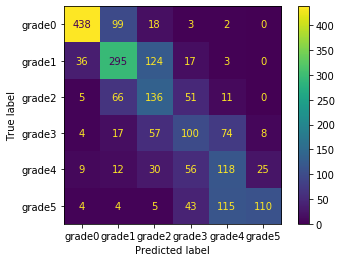

In [43]:
cmd.plot(values_format='d');

In [55]:
cm = confusion_matrix(val_targets, val_o_outputs2)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

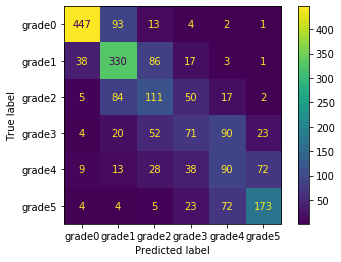

In [56]:
cmd.plot(values_format='d');

In [60]:
w

tensor([[ 0.,  1.,  4.,  9., 16., 25.],
        [ 1.,  0.,  1.,  4.,  9., 16.],
        [ 4.,  1.,  0.,  1.,  4.,  9.],
        [ 9.,  4.,  1.,  0.,  1.,  4.],
        [16.,  9.,  4.,  1.,  0.,  1.],
        [25., 16.,  9.,  4.,  1.,  0.]])

In [75]:
cm = confusion_matrix(val_targets, val_o_outputs)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

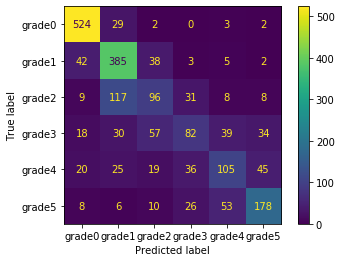

In [76]:
cmd.plot(values_format='d');

In [56]:
cm = confusion_matrix(val_targets, val_o_outputs_reg)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

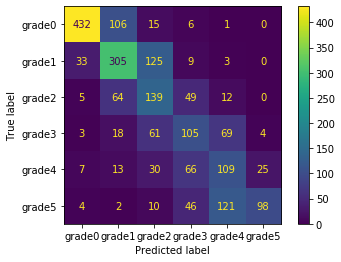

In [57]:
cmd.plot(values_format='d');

In [58]:
cm = confusion_matrix(val_targets, val_o_outputs_class)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

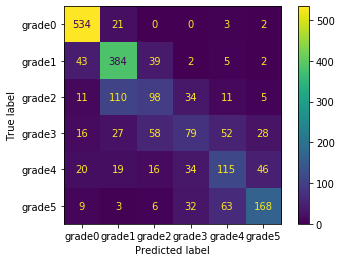

In [59]:
cmd.plot(values_format='d');

In [ ]:
coefficients = optimized_rounder.coefficients()
final_preds = optimized_rounder.predict(preds, coefficients)

In [19]:
import scipy as sp
from functools import partial

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')


class OptimizedRounder():
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
output, target

In [44]:
o_output = output.argmax(dim=-1)

In [45]:
o_output

tensor([1, 0, 3, 5, 1, 1, 2, 1, 0, 0, 1, 0, 5, 4, 4, 4, 5, 1, 3, 0, 2, 3, 0, 0,
        1, 3, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3, 4, 3, 0, 4, 1, 0, 2, 1, 5, 5, 1, 3,
        0, 0, 5, 1, 0, 1, 5, 5, 3, 1, 1, 0, 0, 0, 0, 4], device='cuda:1')

In [46]:
target

tensor([5, 0, 3, 4, 1, 4, 3, 0, 0, 0, 1, 3, 5, 3, 4, 5, 5, 1, 4, 0, 3, 5, 0, 1,
        0, 1, 0, 0, 1, 2, 2, 1, 0, 2, 1, 3, 3, 4, 0, 0, 1, 2, 1, 1, 5, 5, 4, 4,
        1, 5, 5, 2, 0, 1, 3, 5, 5, 1, 1, 0, 4, 0, 0, 4], device='cuda:1')

In [49]:
cohen_kappa_score(o_output.cpu().numpy(), target.cpu().numpy(), weights="quadratic")

0.6770040959625512

In [ ]:
oh_target = torch.tensor((b, max_lbl_nums), device=main_device)
oh_o_output = torch.tensor((b, max_lbl_nums), device=main_device)

In [ ]:
o_output

In [ ]:
oh_target[target] = 1
oh_o_output[o_output] = 1

In [52]:
cm = torch.matmul(oh_target[:, :, None], oh_o_output[:, None, :]).sum(0)

In [ ]:
@dataclass
class KappaScore(ConfusionMatrix):
    "Computes the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [58]:
w = torch.zeros((6, 6))
w += torch.arange(6, dtype=torch.float)
w = (w - torch.t(w)) ** 2

In [59]:
w

tensor([[ 0.,  1.,  4.,  9., 16., 25.],
        [ 1.,  0.,  1.,  4.,  9., 16.],
        [ 4.,  1.,  0.,  1.,  4.,  9.],
        [ 9.,  4.,  1.,  0.,  1.,  4.],
        [16.,  9.,  4.,  1.,  0.,  1.],
        [25., 16.,  9.,  4.,  1.,  0.]])

In [31]:
#empty_mask = (main_features.view(b, max_len, -1) == 0).all(dim=-1)[..., None, None, None]
#dummy_feature = nn.Parameter(torch.ones((1, 1, 512, 8, 8), dtype=torch.float32, device=main_device))
#main_features = main_features + empty_mask * dummy_feature.expand(b, 1, 512, 8, 8)

In [ ]:
# 8*55 - 200 сек

In [ ]:
# imgs, ys, xs, provider, isup_grade, gleason_score

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_wsipatches_dataset_iter = iter(train_wsipatches_dataset)

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(18, 18))
axs = axs.ravel()
n = 0
for imgs, ys, xs, provider, isup_grade, gleason_score in train_wsipatches_dataset_iter:
    imgs = imgs.transpose([0, 2, 3, 1])
    height = ys.max() + 1
    width = xs.max() + 1
    wsi_img = np.zeros((height, width, 3), dtype=np.float32)
    for y, x, img in zip(ys, xs, imgs):
        wsi_img[y, x] = img.reshape(-1, 3).mean(0)
        
    axs[n].imshow(wsi_img);
    axs[n].set_title(f"{n}: {provider}")
    
    n += 1
    
    if n == 36:
        break